로보어드바이져의 제작 단계계

1. 과거 주가 데이터에 근거해서 "나의 전략"을 평가해본다. 
2. 이를 위해 주가 데이터를 가져온다.
3. 주가 데이터를 가지고 "투자 의사결정의 기준선"을 가져온다.
4. 기준선을 가지고 Sell, Buy 조건을 설정한다.
5. 성과를 평가한다.

Step#1 주가데이터 "라이브러리"를 불러오고, 이를 이용해서 기준선을 가져오기

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

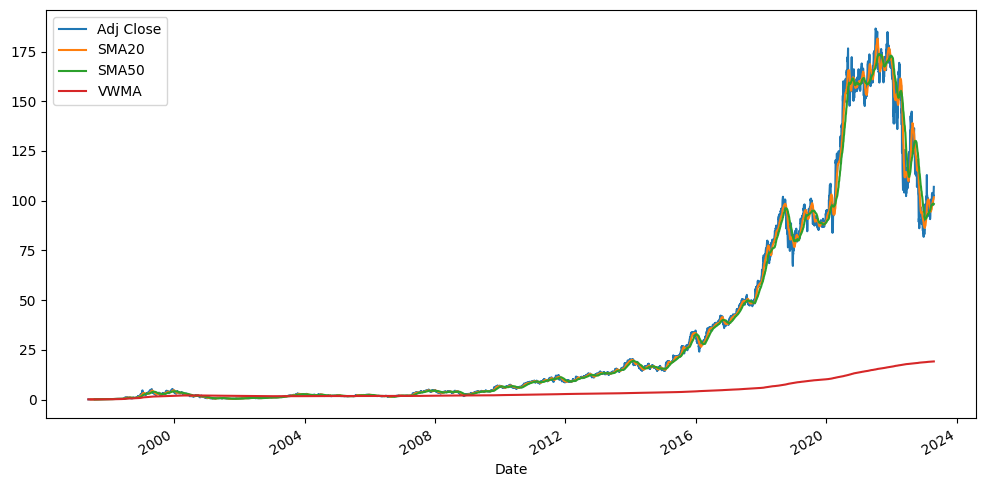

In [ ]:
import pandas as pd
import yfinance as yf

# 아마존 주식 데이터 가져오기
amzn = yf.download('AMZN')

# 이동평균선 계산
amzn['SMA20'] = amzn['Adj Close'].rolling(window=20).mean()
amzn['SMA50'] = amzn['Adj Close'].rolling(window=50).mean()

# 거래량 가중 이동평균 계산
amzn['VWMA'] = (amzn['Volume'] * amzn['Adj Close']).cumsum() / amzn['Volume'].cumsum()

# 시각화
amzn[['Adj Close', 'SMA20', 'SMA50', 'VWMA']].plot(figsize=(12, 6))

Step#2 투자의사 결정 기준 만들기

In [ ]:
import yfinance as yf

# 아마존 주식 데이터 가져오기
amzn = yf.download('AMZN')

# 이동평균선 계산
amzn['SMA20'] = amzn['Adj Close'].rolling(window=20).mean()
amzn['SMA50'] = amzn['Adj Close'].rolling(window=50).mean()

# 거래량 가중 이동평균 계산
amzn['VWMA'] = (amzn['Volume'] * amzn['Adj Close']).cumsum() / amzn['Volume'].cumsum()

# 로보어드바이져
if amzn['SMA20'][-1] > amzn['SMA50'][-1] and amzn['VWMA'][-1] > amzn['Adj Close'][-1]:
    print("Buy AMZN")
else:
    print("Sell AMZN")

[*********************100%***********************]  1 of 1 completed
Sell AMZN


Step#3 시뮬레이션(백테스팅)

[*********************100%***********************]  1 of 1 completed


<ipython-input-3-bd1743ecd7bd>:17: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  amzn['Advice'] = pd.Series(index=amzn.index)
<ipython-input-3-bd1743ecd7bd>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amzn['Advice'][i] = 0  # Sell
<ipython-input-3-bd1743ecd7bd>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amzn['Advice'][i] = 1  # Buy


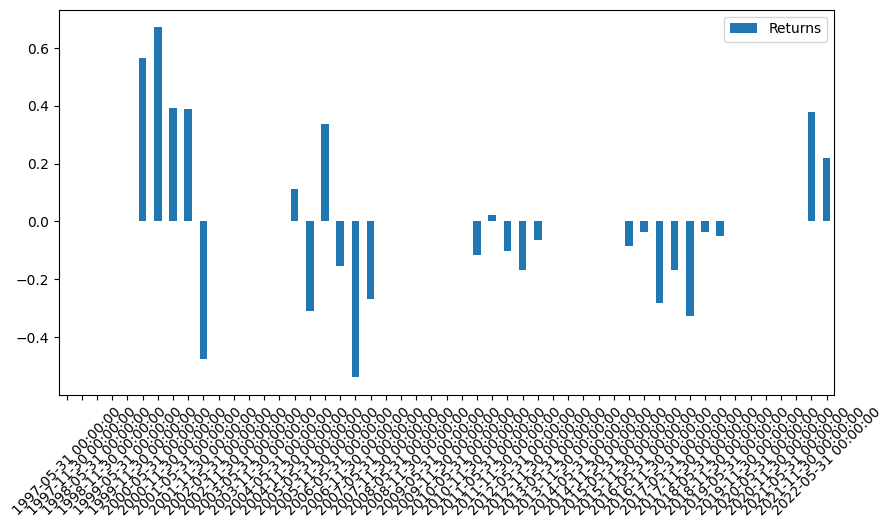

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 아마존 주식 데이터 가져오기
amzn = yf.download('AMZN')

# 이동평균선 계산
amzn['SMA20'] = amzn['Adj Close'].rolling(window=20).mean()
amzn['SMA50'] = amzn['Adj Close'].rolling(window=50).mean()

# 거래량 가중 이동평균 계산
amzn['VWMA'] = (amzn['Volume'] * amzn['Adj Close']).cumsum() / amzn['Volume'].cumsum()

# 로보어드바이져
amzn['Advice'] = pd.Series(index=amzn.index)

for i in range(50, len(amzn)):
    if amzn['SMA20'][i] > amzn['SMA50'][i] and amzn['VWMA'][i] > amzn['Adj Close'][i]:
        amzn['Advice'][i] = 1  # Buy
    else:
        amzn['Advice'][i] = 0  # Sell

# 주가 데이터 분할
start_date = amzn.index[0]
end_date = amzn.index[-1]
split_date = pd.date_range(start=start_date, end=end_date, freq='6M')

# 예측 결과와 실제 결과 비교
results = pd.DataFrame(columns=['Returns'])

for i in range(len(split_date) - 1):
    start = split_date[i]
    end = split_date[i+1]

    if start not in amzn.index or end not in amzn.index:
        actual_return = np.nan
    else:
        actual_price_diff = amzn['Adj Close'][end] - amzn['Adj Close'][start]
        if actual_price_diff == 0:
            actual_return = np.nan
        else:
            actual_return = np.log(amzn['Adj Close'][end] / amzn['Adj Close'][start])
    predicted_return = 0

    for j in range(len(amzn[start:end])):
        if amzn['Advice'][j] == 1:
            predicted_return += np.log(amzn['Adj Close'][j+start+1] / amzn['Adj Close'][j+start])
        else:
            predicted_return += 0

    result = pd.DataFrame({'Returns': [predicted_return - actual_return]})
    results = pd.concat([results, result], axis=0)

# 그래프 생성
fig, ax = plt.subplots(figsize=(10, 5))

results.plot(ax=ax, kind='bar')
ax.set_xticklabels(split_date[:-1], rotation=45)

plt.show()